In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jaxopt
import pyproximal
import pylops
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import multidms

In [2]:
# max number of warmup iterations with post-latent GE (if any) remains fixed
warmup_iterations = 10

# total number of iterations to optimize
max_total_iterations = 100

# error tolerance for early stopping (convergence criteria)
error_tolerance = 1e-4

# data params
data_replicate = 2

# modeling params
equivariant = False
post_latent_fn = "sigmoid"
smooth_obj_fn = "cond_norm_penalty"
weighted_by_variant_support = False

init_beta_normal = False # False initializes beta's to be zero

# only relevant to the sigmoid post latent fn
theta_scale = 6.0
theta_bias = -3.5
lock_sigmoid_params = False
theta_scale_upper_bound = 10
l2reg_theta_scale = 0

# other fitting hyperparameters
# the weights we use for the manusctript are:
# "lasso_coeff" : [0.0, 5.00e-6, 1.00e-05, 2.00e-05, 4.00e-05, 8.00e-05, 1.60e-04, 3.20e-04, 6.40e-04]
lasso_coeff = 4e-5
l2reg_beta = 1e-3

output_dir = "results/output"

### Count aggregation

aggregate unfiltered counts, then compute a single functional score for each variant

In [3]:
func_scores_df = pd.read_csv(
    "../input/spike_func_scores_unfiltered_counts.csv").fillna("").drop(columns="func_score")

func_scores_df

,pre_count,post_count,aa_substitutions,condition,replicate,n_subs
0,235,331,N87T L517F T1006A,Delta,1,3
1,234,682,D80L,Delta,1,1
2,234,145,A1026V D1168Y,Delta,1,2
3,234,546,G75W K1154E,Delta,1,2
4,234,103,T307S S803L A893V,Delta,1,3
...,...,...,...,...,...,...
770281,287,187,P82S S112T D138T K1038N,Omicron_BA2,2,4
770282,287,170,L179P A222T G261H N405D,Omicron_BA2,2,4
770283,287,58,S27F G413E,Omicron_BA2,2,2
770284,287,488,A222V S1242I,Omicron_BA2,2,2


In [4]:
groups = func_scores_df.groupby(["aa_substitutions", "condition", "replicate"])

func_scores_collapsed_df = groups.agg(
    dict(pre_count="sum", post_count="sum", aa_substitutions="first", condition="first", replicate="first", n_subs="first")
).assign(barcodes=groups.size()).reset_index(drop=True)

pseudocount = 0
func_scores_collapsed_df["func_score"] = np.log2(func_scores_collapsed_df.post_count + pseudocount) - np.log2(func_scores_collapsed_df.pre_count + pseudocount)

# normalize to WT for each condition
groups = func_scores_collapsed_df.groupby(["condition", "replicate"])
for (condition, replicate), group in groups:
    wt = group.query("aa_substitutions == ''").func_score.squeeze()
    func_scores_collapsed_df.loc[group.index, "func_score"] -= wt

func_scores_collapsed_df

/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,pre_count,post_count,aa_substitutions,condition,replicate,n_subs,barcodes,func_score
0,5027212,4967837,,Delta,1,0,10176,0.000000
1,5955236,3000775,,Delta,2,0,8516,0.000000
2,13479201,16707349,,Omicron_BA1,1,0,24216,0.000000
3,15250884,19953602,,Omicron_BA1,2,0,22495,0.000000
4,15195250,12396402,,Omicron_BA2,1,0,21020,0.000000
...,...,...,...,...,...,...,...,...
335519,499,71,Y91V S98Y D138* Y144V N280D N405P P463S S982R ...,Omicron_BA2,2,9,2,-3.160077
335520,166,0,Y91V T108A G261H,Omicron_BA1,2,3,1,-inf
335521,888,71,Y91V T883I,Omicron_BA2,2,2,2,-3.991597
335522,303,0,Y91V V401L K679A D1163G,Omicron_BA1,2,4,1,-inf


Filter the aggregated counts

In [5]:
func_scores_collapsed_df.query("(pre_count >= 100) & (post_count > 0)", inplace=True)
func_scores_collapsed_df.shape

(295757, 8)

In [6]:
func_scores_collapsed_df

,pre_count,post_count,aa_substitutions,condition,replicate,n_subs,barcodes,func_score
0,5027212,4967837,,Delta,1,0,10176,0.000000
1,5955236,3000775,,Delta,2,0,8516,0.000000
2,13479201,16707349,,Omicron_BA1,1,0,24216,0.000000
3,15250884,19953602,,Omicron_BA1,2,0,22495,0.000000
4,15195250,12396402,,Omicron_BA2,1,0,21020,0.000000
...,...,...,...,...,...,...,...,...
335513,633,8,Y91V E132Q Q675L A845E G1167D,Omicron_BA1,2,5,1,-6.693818
335514,497,7,Y91V H505N I1216T,Omicron_BA1,2,3,1,-6.537503
335517,310,26,Y91V S112N M177K L335P N405A C671R K679R T859A...,Omicron_BA2,2,9,2,-3.922613
335519,499,71,Y91V S98Y D138* Y144V N280D N405P P463S S982R ...,Omicron_BA2,2,9,2,-3.160077


Replicate correlations

/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

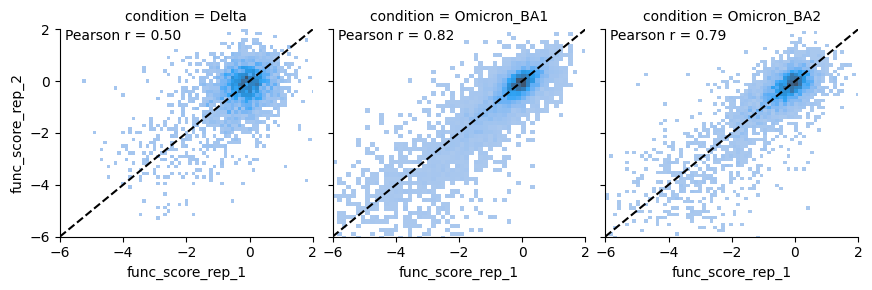

In [7]:
tmp = func_scores_collapsed_df.pivot(index=["aa_substitutions", "condition"], columns="replicate", values="func_score").reset_index()
tmp.rename(columns={1: "func_score_rep_1", 2: "func_score_rep_2"}, inplace=True)
tmp.dropna(inplace=True)
g = sns.displot(data=tmp, col="condition", x="func_score_rep_1", y="func_score_rep_2", height=3, 
                kind="hist", common_norm=False, common_bins=False)
for d, ax in zip(g.col_names, g.axes.flat):
    ax.plot([-6, 2], [-6, 2], "k--")
    ax.set_xlim(-6, 2)
    ax.set_ylim(-6, 2)
    ax.annotate(f"Pearson r = {scipy.stats.pearsonr(tmp.query('condition == @d').func_score_rep_1, tmp.query('condition == @d').func_score_rep_2).statistic:.2f}", (0.02, 0.95), xycoords="axes fraction")

Distribution of number of barcodes

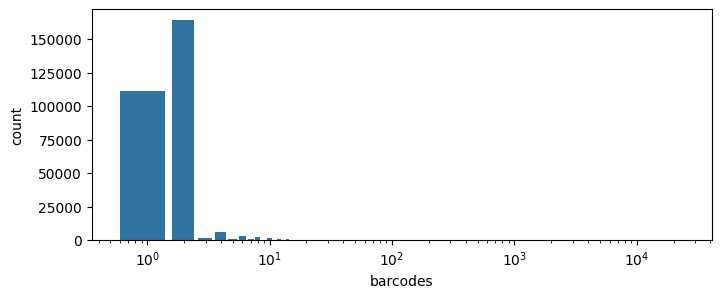

In [8]:
plt.figure(figsize=(8, 3))
sns.countplot(x=func_scores_collapsed_df.barcodes, native_scale=True)
plt.xscale("log")
# plt.yscale("log")
plt.show()

Distribution of number of mutations

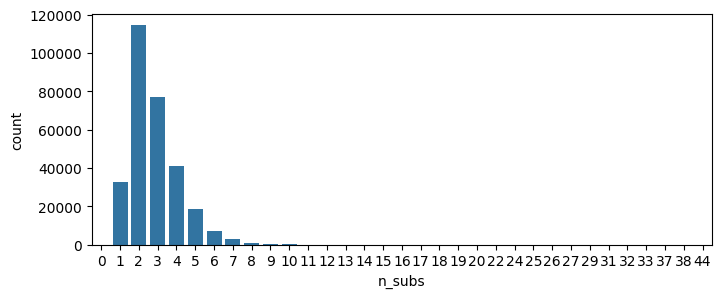

In [9]:
plt.figure(figsize=(8, 3))
sns.countplot(x=func_scores_collapsed_df.n_subs)
plt.show()

Number of variants in each condition

<Axes: xlabel='condition', ylabel='count'>

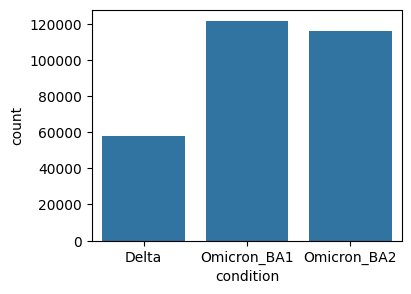

In [10]:
plt.figure(figsize=(4, 3))
sns.countplot(data=func_scores_collapsed_df, x="condition")

Add a weight, which can be used in fitting

In [11]:
if weighted_by_variant_support:
    func_scores_collapsed_df['weight'] = np.sqrt(func_scores_collapsed_df['barcodes'])
else:
    func_scores_collapsed_df['weight'] = 1.0

func_scores_collapsed_df.head(10)

,pre_count,post_count,aa_substitutions,condition,replicate,n_subs,barcodes,func_score,weight
0,5027212,4967837,,Delta,1,0,10176,0.000000,1.0
1,5955236,3000775,,Delta,2,0,8516,0.000000,1.0
2,13479201,16707349,,Omicron_BA1,1,0,24216,0.000000,1.0
3,15250884,19953602,,Omicron_BA1,2,0,22495,0.000000,1.0
4,15195250,12396402,,Omicron_BA2,1,0,21020,0.000000,1.0
5,18959708,24113895,,Omicron_BA2,2,0,19832,0.000000,1.0
6,978,291,A1015D,Delta,1,1,2,-1.731675,1.0
7,853,156,A1015D,Delta,2,1,2,-1.462176,1.0
9,644,24,A1015D,Omicron_BA2,1,1,2,-4.452255,1.0
10,796,268,A1015D E1188Q,Delta,1,2,2,-1.553395,1.0


Isolate a single replicate

In [12]:
func_scores_collapsed_df.query(f"replicate == {data_replicate}", inplace=True)
func_scores_collapsed_df

,pre_count,post_count,aa_substitutions,condition,replicate,n_subs,barcodes,func_score,weight
1,5955236,3000775,,Delta,2,0,8516,0.000000,1.0
3,15250884,19953602,,Omicron_BA1,2,0,22495,0.000000,1.0
5,18959708,24113895,,Omicron_BA2,2,0,19832,0.000000,1.0
7,853,156,A1015D,Delta,2,1,2,-1.462176,1.0
14,3757,2030,A1015S,Delta,2,1,6,0.100722,1.0
...,...,...,...,...,...,...,...,...,...
335513,633,8,Y91V E132Q Q675L A845E G1167D,Omicron_BA1,2,5,1,-6.693818,1.0
335514,497,7,Y91V H505N I1216T,Omicron_BA1,2,3,1,-6.537503,1.0
335517,310,26,Y91V S112N M177K L335P N405A C671R K679R T859A...,Omicron_BA2,2,9,2,-3.922613,1.0
335519,499,71,Y91V S98Y D138* Y144V N280D N405P P463S S982R ...,Omicron_BA2,2,9,2,-3.160077,1.0


In [13]:
# clip functional scores with a floor of -3.5
func_scores_collapsed_df["func_score"] = func_scores_collapsed_df.func_score.clip(-3.5, 2.5)
# func_scores_collapsed_df.query("func_score >= -3.5 & func_score <= 2.5", inplace=True)
# func_scores_collapsed_df.shape

Define the multidms data object

In [14]:
data = multidms.Data(
        # func_scores_df,
        func_scores_collapsed_df,
        # collapse_identical_variants="mean",
        alphabet=multidms.AAS_WITHSTOP_WITHGAP,
        reference="Omicron_BA1",
        # reference="Omicron_BA2",
        # reference="Delta",
        assert_site_integrity=False,
        verbose=False,
        name=f"rep-{data_replicate}" 
    )
data

/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/jgallowa/mambaforge/envs/multidms-dev/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and J

Data(rep-2)

In [15]:
data.training_data

{'X': {'Delta': BCOO(int8[26743, 10722], nse=869823),
  'Omicron_BA1': BCOO(int8[53209, 10722], nse=137253),
  'Omicron_BA2': BCOO(int8[51122, 10722], nse=853243)},
 'y': {'Delta': Array([ 0.        , -1.46217618,  0.10072214, ..., -0.95950872,
         -3.0166309 , -3.39281081], dtype=float64),
  'Omicron_BA1': Array([ 0.        , -0.1441993 ,  0.15470144, ..., -3.5       ,
         -3.5       , -3.5       ], dtype=float64),
  'Omicron_BA2': Array([ 0.        , -0.04110356, -0.62651354, ..., -3.3366282 ,
         -3.5       , -3.5       ], dtype=float64)},
 'w': {'Delta': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64),
  'Omicron_BA1': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64),
  'Omicron_BA2': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64)}}

Plot the distribution of row-sums of $X$, and the distribution of $y$

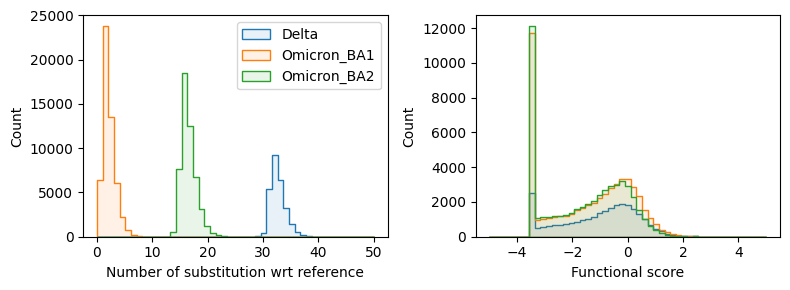

In [16]:
plt.figure(figsize=(8, 3))
for d in data.conditions:
    Xd = data.training_data["X"][d]
    yd = data.training_data["y"][d]
    plt.subplot(121)
    sns.histplot(Xd.sum(1).todense(), bins=np.linspace(0, 50, 50), label=d, element="step", alpha=0.1)
    plt.legend()
    plt.xlabel("Number of substitution wrt reference")
    plt.subplot(122)
    sns.histplot(x=yd, bins=np.linspace(-5, 5, 50), element="step", alpha=0.1)
    plt.xlabel("Functional score")
plt.tight_layout()
plt.show()

Define reference condition

In [17]:
ref_condition = data.reference
ref_condition_idx = data.conditions.index(ref_condition)
ref_condition, ref_condition_idx

('Omicron_BA1', 1)

## Modeling

Given any 1-hot encoding $X_d\in\{0,1\}^{n_d\times M}, d=1\dots,D$, we pose the regression problem as

### Reference Shift Model

$$
y_d = g_\theta\left(\beta_0 + \alpha_d + \sum_{m} (\beta_{m} + \Delta_{m, d})x_{m,d}\right)
$$

Where:

* $\beta_0$ is a wildtype offset parameter applied to the latent prediction of all experiments.
* $\alpha_d$ is a set of bias parameters, optionally applied to the latent phenotype of all _non-reference_ experiments. These parameters may capture the effect of the _bundle_ of non-identical mutations which may exist between experiments.
* $\beta_{m}$ is the latent phenotypic effect of mutation $m$ shared by all experiments (See the note below), 
* $\Delta_{d, m}$ is the shift of the effect of mutation $m$ in condition $d$.
* $v$ is the set of all mutations relative to the reference wild type sequence including all potential non-identical wildtype mutations that separate condition $d$ from the reference condition.

### Generalized Lasso Model

$$
y_{d} = g_\theta\left(\beta_{0,d} + \sum_m\beta_{m,d} \ x_{m,d}\right) + \epsilon_{d}.
$$
The shifts of mutation effects between conditions $d$ and $d'$ are
$$
\Delta_{m,d,d'} = \beta_{m,d} - \beta_{m,d'},
$$
and the shifts between WTs are
$$
\alpha_{d,d'} = \beta_{0,d} - \beta_{0,d'}.
$$
We will usually use a 1-hot encoding referenced to the WT sequence from one of the $D$ conditions, so that the mutation effects and shifts are interpreted wrt to that condition.
This introduces parameter scaling problems in the non-reference conditions that confound gradient methods, arising from the set of "bundle" sites that define the divergence from the reference encoding (more on this below).
For now, note that the choice of reference condition for interpreting shifts can be made *a posteriori* by fixing $d'$, recovering the parameterization in the main text.

In [18]:
# @jax.jit
def φ_pred_fn(params, data):
    result = {}
    for d in data["X"]:
        β0d = params["β0"][d]
        βd = params["β"][d]
        Xd = data["X"][d]
        # theta = params["θ"]
        result[d] = β0d + Xd @ βd
    return result

In [19]:

def sigmoidal_global_epistasis(theta: dict, z_d: jnp.array):
    r"""
    A flexible sigmoid function for modeling global epistasis.
    This function takes a set of latent phenotype values, :math:`z_d`
    and computes the predicted functional scores using the scaling parameters
    :math:`\theta_{\text{scale}}` and :math:`\theta_{\text{bias}}`
    such that:

    .. math::
        g(z) =  \frac{\theta_{\text{scale}}}{1 + e^{-z}} + \theta_{\text{bias}}

    .. note::
        this function is independent from the
        experimental condition from which a variant is observed.

    Parameters
    ----------
    theta : dict
        Dictionary of model defining parameters as jax arrays.
    z_d : jnp.array
        Latent phenotype values for a given set of variants

    Returns
    -------
    jnp.array
        Predicted functional scores for each latent phenotype in ``z_d``.
    """
    activations = jax.nn.sigmoid(z_d[:, None])
    return (theta["theta_scale"] @ activations.T) + theta["theta_bias"]


def identity_activation(d_params, act, **kwargs):
    """
    Identity function :math:`f(x)=x`.
    Mostly a ghost function which helps compose
    the model when you don't want to use any final output activation e.g.
    you don't have a pre-defined lower bound.
    """
    return act

Functional score prediction

In [20]:
if post_latent_fn == "linear":
    g_pred_fn = identity_activation
elif post_latent_fn == "sigmoid":
    g_pred_fn = sigmoidal_global_epistasis
    
def y_pred_fn(params, data):
    φ_pred = φ_pred_fn(params, data)
    result = {}
    theta = params["θ"]
    for d in data["X"]:
        result[d] = g_pred_fn(theta, φ_pred[d])
    return result

## Smooth peice of the objective function



Let $N = \sum_{d=1}^{D}N_d$

$$
\min_{\beta_0,\beta,\theta} \frac{1}{N} \sum_{d=1}^D  \sum_{(x, y)\in\mathcal{D}_d}^{N_d}\!\!\ell(y,\hat{y}_d(x)) + \lambda\|\beta_d\|^2_2,
$$



In [21]:
@jax.jit
def all_sample_normalized_loss(
    params, 
    data, 
    condition_weights, 
    l2reg_beta=0.0, 
    l2reg_theta_scale=0.0, 
    huber_delta=1.0,
):
    conditional_loss = 0.0
    N = 0
    for d, yd_pred in y_pred_fn(params, data).items():

        yd = data["y"][d]
        βd = params["β"][d]
        N_d = yd.shape[0]
        wd = condition_weights[d] * data["w"][d]

        conditional_loss += (
            wd * jaxopt.loss.huber_loss(yd, yd_pred, delta=huber_delta)
        ).sum()
        
        conditional_loss += l2reg_beta * (βd**2).sum()

        N += N_d 

    conditional_loss /= N

    θ = params["θ"]
    theta_penalty = l2reg_theta_scale * (θ["theta_scale"]**2).sum()

    return conditional_loss + theta_penalty

$$
\min_{\beta_0,\beta,\theta} \frac{1}{D} \sum_{d=1}^D \left(\frac{1}{N_d} \sum_{(x, y)\in\mathcal{D}_d}^{N_d}\!\!\ell(y,\hat{y}_d(x)) + \lambda\|\beta_d\|^2_2\right)
$$

In [22]:
# jared's loss
@jax.jit
def condition_normalized_penalty_loss(
    params, 
    data, 
    condition_weights, 
    l2reg_beta=0.0, 
    l2reg_theta_scale=0.0, 
    huber_delta=1.0,
):
    conditional_loss = 0.0
    for d, yd_pred in y_pred_fn(params, data).items():

        yd = data["y"][d]
        βd = params["β"][d]
        N_d = yd.shape[0]
        wd = condition_weights[d] * data["w"][d]

        huber_loss = (
            wd * jaxopt.loss.huber_loss(yd, yd_pred, delta=huber_delta)
        ).sum()

        beta_ridge_penalty = l2reg_beta * (βd**2).sum()
        conditional_loss += (huber_loss + beta_ridge_penalty) / N_d

    D = len(data["X"])
    conditional_loss /= D

    θ = params["θ"]
    theta_penalty = l2reg_theta_scale * (θ["theta_scale"]**2).sum()

    return conditional_loss + theta_penalty

$$
\min_{\beta_0,\beta,\theta} \frac{1}{D} \sum_{d=1}^D \left(\frac{1}{N_d} \sum_{(x, y)\in\mathcal{D}_d}^{N_d}\!\!\ell(y,\hat{y}_d(x))\right) + \frac{1}{N} \lambda\|\beta\|^2_2
$$

In [23]:
@jax.jit
def condition_normalized_equal_penalty_loss(
    params, 
    data, 
    condition_weights, 
    l2reg_beta=0.0, 
    l2reg_theta_scale=0.0, 
    huber_delta=1.0,
):
    N = 0
    huber_result = 0.0
    beta_ridge_penalty = 0.0
    
    for d, yd_pred in y_pred_fn(params, data).items():

        yd = data["y"][d]
        βd = params["β"][d]
        N_d = yd.shape[0]
        wd = condition_weights[d] * data["w"][d]

        huber_result += (
            wd * jaxopt.loss.huber_loss(yd, yd_pred, delta=huber_delta)
        ).mean()

        beta_ridge_penalty += l2reg_beta * (βd**2).sum()

        N += N_d

    D = len(data["X"]) 

    huber_result /= D
    beta_ridge_penalty /= N
    conditional_loss = huber_result + beta_ridge_penalty

    θ = params["θ"]
    theta_penalty = l2reg_theta_scale * (θ["theta_scale"]**2).sum()

    return conditional_loss + theta_penalty

$$
\min_{\beta_0,\beta,\theta} \frac{1}{D} \sum_{d=1}^D \left(\frac{1}{N_d} \sum_{(x, y)\in\mathcal{D}_d}^{N_d}\!\!\ell(y,\hat{y}_d(x))\right) + \lambda\|\beta\|^2_2
$$

In [24]:
@jax.jit
def condition_normalized_sum_penalty_loss(
    params, 
    data, 
    condition_weights, 
    l2reg_beta=0.0, 
    l2reg_theta_scale=0.0, 
    huber_delta=1.0,
):
    huber_result = 0.0
    beta_ridge_penalty = 0.0
    
    for d, yd_pred in y_pred_fn(params, data).items():

        yd = data["y"][d]
        βd = params["β"][d]
        N_d = yd.shape[0]
        wd = condition_weights[d] * data["w"][d]

        huber_result += (
            wd * jaxopt.loss.huber_loss(
                yd, 
                yd_pred, 
                delta=huber_delta
            )
        ).mean()

        beta_ridge_penalty += l2reg_beta * (βd**2).sum()

    D = len(data["X"]) 
    huber_result /= D
    conditional_loss = huber_result + beta_ridge_penalty

    θ = params["θ"]
    theta_penalty = l2reg_theta_scale * (θ["theta_scale"]**2).sum()

    return conditional_loss + theta_penalty

In [25]:
smooth_obj_fn_dict = {
    "all_sample_norm" : all_sample_normalized_loss,
    "cond_norm_penalty": condition_normalized_penalty_loss,
    "cond_norm_equal_penalty": condition_normalized_equal_penalty_loss,
    "cond_norm_sum_penalty": condition_normalized_sum_penalty_loss
}

In [26]:
from functools import partial
from jax.tree_util import Partial
smooth_objective = jax.jit(smooth_obj_fn_dict[smooth_obj_fn])

### Data scale adjustments

To appropriately scale regression parameters, we need condition-specific 1-hot encodings, each wrt the WT in that condition. We get this by bit flipping the "bundle" sites in all conditions.
Now each condition has data referenced to its own WT.

In [27]:
def rereference(X, cols):
    """Flip bits on columns (bool idxs)"""
    if cols.sum():
        X_scipy = scipy.sparse.csr_matrix((X.data, (X.indices[:, 0], X.indices[:, 1])), shape=X.shape).tolil()
        tmp = X_scipy[: , cols].copy()
        X_scipy[: , cols] = 1
        X_scipy[: , cols] -= tmp
        X_scaled = jax.experimental.sparse.BCOO.from_scipy_sparse(X_scipy)
        X_scaled = jax.experimental.sparse.BCOO((X_scaled.data.astype(jnp.int8), X_scaled.indices), shape=X.shape)

        assert (X[:, cols].sum(0).todense() + X_scaled[:, cols].sum(0).todense() == X.shape[0]).all()

    else:
        X_scaled = X

    return X_scaled


scaled_data = {"X": {}, "y": data.training_data["y"], "w": data.training_data["w"]}

bundle_idxs = {}
bundle_signs = {}

for d in data.training_data["X"]:
    print(d)
    bundle_idxs[d] = data.training_data["X"][d].sum(0).todense() / data.training_data["X"][d].shape[0] > 0.5
    bundle_signs[d] = jnp.where(bundle_idxs[d], -1, 1)

    scaled_data["X"][d] = rereference(data.training_data["X"][d], bundle_idxs[d])

scaled_data

Delta


Omicron_BA1
Omicron_BA2


{'X': {'Delta': BCOO(int8[26743, 10722], nse=78045),
  'Omicron_BA1': BCOO(int8[53209, 10722], nse=137253),
  'Omicron_BA2': BCOO(int8[51122, 10722], nse=158121)},
 'y': {'Delta': Array([ 0.        , -1.46217618,  0.10072214, ..., -0.95950872,
         -3.0166309 , -3.39281081], dtype=float64),
  'Omicron_BA1': Array([ 0.        , -0.1441993 ,  0.15470144, ..., -3.5       ,
         -3.5       , -3.5       ], dtype=float64),
  'Omicron_BA2': Array([ 0.        , -0.04110356, -0.62651354, ..., -3.3366282 ,
         -3.5       , -3.5       ], dtype=float64)},
 'w': {'Delta': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64),
  'Omicron_BA1': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64),
  'Omicron_BA2': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64)}}

Plot the distribution of row-sums of $X$ in the rescaled data. Much nicer!

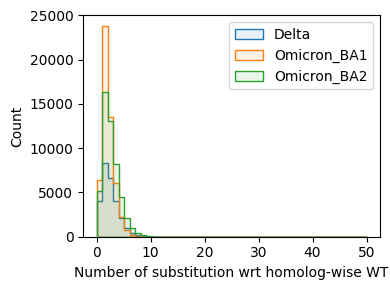

In [28]:
plt.figure(figsize=(4, 3))
for d in data.conditions:
    Xd = scaled_data["X"][d]
    yd = scaled_data["y"][d]
    sns.histplot(Xd.sum(1).todense(), bins=np.linspace(0, 50, 50), label=d, element="step", alpha=0.1)
    plt.legend()
    plt.xlabel("Number of substitution wrt homolog-wise WT")
plt.tight_layout()
plt.show()

## Parameter transformation

Consider just one condition, so that we suppress the index $d$ below for simplicity.
Let $\mathcal{B}$ be the set of indices of the columns of $X$ corresponding to the bundle. We want to work with rescaled data $1-x_m$ at sites $m\in\mathcal{B}$ in the bundle, and $x_m$ at sites $m\notin\mathcal{B}$ not in the bundle. Let $\tilde\beta_0$ and $\tilde\beta_m$ be the intercept and coefficients in the rescaled problem, and $\beta_0$ and $\beta_m$ be the intercept and coefficients in the original data. The equivalence of latent phenotype predictions between scales requires
$$
\tilde\beta_0 + \sum_{m\notin\mathcal{B}}\tilde\beta_m x_m + \sum_{m\in\mathcal{B}}\tilde\beta_m(1 - x_m) = \beta_0 + \sum_m\beta_m x_m.
$$
Matching like terms, we find
$$
\beta_0 = \tilde\beta_0 + \sum_{m\in\mathcal{B}}\tilde\beta_m = \tilde\beta_0 - \sum_{m\in\mathcal{B}}\beta_m,
$$
and
$$
\beta_m =
\begin{cases}
\tilde\beta_m, & m\notin\mathcal{B} \\
-\tilde\beta_m, & m\in\mathcal{B}
\end{cases}.
$$
Note that $\tilde\beta_m^{\mathrm{ref}} = \beta_m^{\mathrm{ref}}$, since $\mathcal{B}^{\mathrm{ref}}=\emptyset$.
Note also that the transform operation is its own inverse.

In [29]:
def transform(params, bundle_idxs):
    params_transformed = {key: val.copy() for key, val in params.items() if key not in ["β", "β0"]}
    params_transformed["β"] = {}
    params_transformed["β0"] = {}
    for d in params["β"]:
        params_transformed["β"][d] = params["β"][d].at[bundle_idxs[d]].mul(-1)
        params_transformed["β0"][d] = params["β0"][d] + params["β"][d][bundle_idxs[d]].sum()
    return params_transformed

## Reference-experiment equivariance during optimization

We currently choose a reference experiment *a priori* and penalize only the differences between each non-reference experiment and the reference experiment.
For this section, consider one mutation, so we suppress the index $m$ below for simplicity.
Our mutation effects across conditions are the vector $β\in\mathbb{R}^D$, and our shift penalty is
$$
\lambda\|\Delta\|_1 = \lambda\|\mathfrak{D} β\|_1,
$$
where, assuming $d=1$ is the reference experiment and $D=3$, we use the difference matrix
$$
\mathfrak{D} = 
\begin{bmatrix}
0 & 0 & 0\\
-1 & 1 & 0\\
-1 & 0 & 1
\end{bmatrix}.
$$
The row of zeros captures the fact that we don't penalize shifts between non-reference experiments.
This lack of symmetry limits the potential sparsity structure of the model.
For example, it's not possible for two non-reference experiments to have the same mutation effect that is different from the reference experiment.
If an epistatic interaction has arisen only on the branch leading to the reference experiment, we can't discover that shift pattern.

This boils down to 

$$
\mathfrak{D}\beta=\begin{bmatrix}
0\\
\beta_2-\beta_1\\
\beta_3-\beta_1
\end{bmatrix},
$$

For example, If $\beta = [2, 1, 2]^T$ then $\mathfrak{D}\beta=[0, -1, 0]^T$.

It would be more natural to infer a reference-equivariant model that fuses across all conditions symmetrically, after which an *a posteriori* choice of reference experiment can be made for mutation effect interpretation.
We would use the difference matrix
$$
\mathfrak{D} = 
\begin{bmatrix}
0 & -1 & 1\\
-1 & 1 & 0\\
-1 & 0 & 1
\end{bmatrix},
$$
where all shifts are penalized symmetrically. Then, 

$$
\mathfrak{D}\beta=\begin{bmatrix}
\beta_3-\beta_2\\
\beta_2-\beta_1\\
\beta_3-\beta_1
\end{bmatrix},
$$

For example, If $\beta = [2, 1, 2]^T$ then $\mathfrak{D}\beta=[1, -1, 0]^T$.

Finally, we can combine this with the parameter transformation above by specifying $\tilde{\mathfrak{D}}$ such that $\tilde{\mathfrak{D}}\tilde\beta = \mathfrak{D}\beta$.
This is achieved by setting $\tilde{\mathfrak{D}} = \mathfrak{D}(I - 2\mathrm{diag}(B))$, where $B$ is the 1-hot encoding of the bundleness across conditions at this site.
The diagonal matrix $(I - 2\mathrm{diag}(B))$ has -1s for conditions for which the site is in the bundle, and 1s for conditions for which the site is not in the bundle.

### ADMM approach

We next derive the proximal operator for the symmetric fusion problem, using standard augmented Lagrangian methods (see citations below).
This is a special case of the generalized lasso.
Our penalized problem is
$$
\min_{\beta} f(\beta) + \lambda\|\mathfrak{D}\beta\|_1,
$$
where $f$ is the smooth piece of the objective.
To use FISTA, we'll need the gradient $\nabla f$ and the proximal operator $\mathrm{prox}_{\lambda}$, defined as
$$
\mathrm{prox}_{\lambda}(x) = \arg\min_{y}\frac{1}{2}\|x - y\|_2^2 + \lambda\|\mathfrak{D}y\|_1,
$$
which is equivalent to the constrained problem
$$
\mathrm{prox}_{\lambda}(x) = \arg\min_{y, z}\frac{1}{2}\|x - y\|_2^2 + \lambda\|z\|_1 \quad \text{s.t.} \quad \mathfrak{D}y - z = 0.
$$
This can be evaluated by ADMM iterations with dual variable $u$:
$$
\begin{aligned}
y^{(k+1)} &= (I + \rho \mathfrak{D}^\intercal \mathfrak{D})^{-1}(x + \rho \mathfrak{D}^\intercal(z^{(k)} - u^{(k)}))\\
z^{(k+1)} &= S_{\lambda/\rho}(\mathfrak{D}y^{(k+1)} + u^{(k)})\\
u^{(k+1)} &= u^{(k)} + \mathfrak{D}y^{(k+1)} - z^{(k+1)},
\end{aligned}
$$
where $S_{\lambda/\rho}$ is the soft-thresholding operator and $\rho>0$ is the ADMM step-size.
These iterations rapidly converge in terms of the primal and dual residuals:
$$
\begin{aligned}
\text{primal residual} &= \|\mathfrak{D}y^{(k+1)} - z^{(k+1)}\|_2\\
\text{dual residual} &= \rho\|D^\intercal(z^{(k+1)} - z^{(k)})\|_2.
\end{aligned}
$$

To parallelize across all mutations, we simply stack in the column dimensions of $y, z, u$. Thus, we have the proximal operator necessary for the general lasso penalized model.

See:
- [Boyd et al.](https://web.stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf) for the generalized lasso problem (see $\S6.4.1$).
- [Tibshirani](https://www.stat.cmu.edu/~ryantibs/convexopt-F15/lectures/21-dual-meth.pdf), slide 21
- [Tibshirani and Taylor](https://www.stat.cmu.edu/~ryantibs/papers/genlasso.pdf) for a treatment of the solution path.


<!-- ### Conjecture

We can avoid ADMM and instead use direct soft-thresholding. Introduce auxiliary variable $\bar\beta\in\mathbb{R}$ (loosely interpretable as a condition averaged effect) and use the simple lasso penalty $\lambda\|\beta - \bar\beta 1_D\|$, for which

$$
\mathrm{prox}_{\lambda}(\beta) = \bar\beta 1_D + S_\lambda(\beta_d - \bar\beta 1_D)
$$

This is probably mathematically equivalent to the problem above with the general ADMM hammer. Even if it's somehow not, it is at least morally equivalent. 😃  -->


In [30]:
if equivariant:
    # uncomment this one to apply the equivariant shift penalty
    D = jnp.array([
        [1, -1, 0],
        [0, 1, -1],
        [-1, 0, 1],
    ], dtype=jnp.float64)
else:
    # apply shift penalties wrt to the reference condition only
    D = jnp.eye(3, 3).at[:, ref_condition_idx].set(-1).at[ref_condition_idx].set(0)

D

Array([[ 1., -1.,  0.],
       [ 0.,  0.,  0.],
       [ 0., -1.,  1.]], dtype=float64)

In [31]:
bundle_sign_matrix = jnp.vstack([bundle_signs[d] for d in data.conditions])
# E.g.
bundle_sign_matrix[:, bundle_idxs["Omicron_BA2"]]

Array([[ 1,  1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],      dtype=int64, weak_type=True)

In [32]:
bundle_sign_matrix.shape

(3, 10722)

In [33]:
D_block_diag = scipy.sparse.block_diag([np.array(D) @ np.diag(bundle_sign_matrix[:, col]) for col in range(len(data.mutations))])
D_block_diag

<32166x32166 sparse matrix of type '<class 'numpy.float64'>'
	with 96498 stored elements in COOrdinate format>

In [34]:
#pylops.FirstDerivative(shape, edge=True, kind='backward')
Dop = pylops.LinearOperator(Op=scipy.sparse.linalg.aslinearoperator(D_block_diag), dtype=D.dtype, shape=D_block_diag.shape) 
Dop

<32166x32166 LinearOperator with dtype=float64>

In [35]:

eig = np.real((Dop.H * Dop).eigs(neigs=1, which='LM')[0])
eig

3.0000000000000036

Prox on scaled parameters

In [36]:
# @jax.jit
def prox(params, hyperparameters, scaling=1.0):
    # see https://pyproximal.readthedocs.io/en/stable/index.html
    λ, niter, τ, μ, theta_scale_upper_bound, lock_params = hyperparameters
    # λ, niter, τ, μ = hyperparameters
    assert 0 < μ < τ / eig
    # params["γ"][ref_condition] = 0.0

    # apply prox
    β_ravel = jnp.vstack(params["β"].values()).ravel(order="F")

    β_ravel, Δ_ravel = pyproximal.optimization.primal.LinearizedADMM(
        pyproximal.L2(b=β_ravel), pyproximal.L1(sigma=scaling * λ), Dop,
        niter=niter, tau=τ, mu=μ,
        x0=β_ravel,
        show=False
        )

    β = β_ravel.reshape(-1, len(β_ravel) // 3, order="F")
    Δ = Δ_ravel.reshape(-1, len(Δ_ravel) // 3, order="F")

    # update β dict
    for i, d in enumerate(params["β"]):
        params["β"][d] = β[i]

    # update shifts
    params["Δ"] = Δ
    # should the following two conditions be within the transform?
    # I'm pretty sure it doesn't matter since the the post latent
    # stuff doesn't interfere with the beta's transformation. 
    # 
    # Though I do wonder if the beta's should be transformed before
    # beting passed to the predictive function? HMM?    
    # clamp theta scale to monotonic, and with optional upper bound
    params["θ"]["theta_scale"] = params["θ"]["theta_scale"].clip(
            # 0, theta_scale_upper_bound
            0, theta_scale_upper_bound
    )
    # Any params to constrain during fit
    if lock_params is not None:
        for key, value in lock_params.items():
            params[key] = value


    # clamp β0 for reference condition in non-scaled parameterization (where it's a box constraint)
    params = transform(params, bundle_idxs)
    params["β0"][ref_condition] = 0.0

            
    params = transform(params, bundle_idxs)

    return params


In [37]:
@jax.jit
def total_objective(params, data, condition_weights, l2reg_beta=0.0, l2reg_theta_scale=0.0, l1reg=0.0, huber_delta=1.0):
    result = smooth_objective(
        params, 
        data, 
        condition_weights, 
        l2reg_beta=l2reg_beta,
        l2reg_theta_scale=l2reg_theta_scale,
        huber_delta=huber_delta
    )
    result += l1reg * jnp.abs(params["Δ"]).sum()
    return result

In [38]:
sigmoid_params = {"theta_scale": jnp.array([theta_scale]), "theta_bias": jnp.array([theta_bias])}

key = jax.random.PRNGKey(23)
params0 = dict(
    # β={d: jnp.zeros(len(data.mutations)) for d in data.conditions},
    β={
        d: (jax.random.normal(shape=(len(data.mutations),), key=k) 
        if init_beta_normal else jnp.zeros(len(data.mutations))) 
        for d,k in zip(data.conditions, jax.random.split(key, len(data.conditions)))
    },
    β0={d: jnp.array(0.0) for d in data.conditions},
    θ=sigmoid_params
    )

params0["Δ"] = jnp.zeros((len(data.conditions), len(data.mutations)))

In [39]:
lock_params = sigmoid_params
prox(params0, (1e-6, 100, 1.0, .99 / eig, theta_scale_upper_bound, lock_params), scaling=1.0)

{'θ': {'theta_scale': Array([6.], dtype=float64),
  'theta_bias': Array([-3.5], dtype=float64)},
 'Δ': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'theta_scale': Array([6.], dtype=float64),
 'theta_bias': Array([-3.5], dtype=float64),
 'β': {'Delta': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
  'Omicron_BA1': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
  'Omicron_BA2': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64)},
 'β0': {'Delta': Array(0., dtype=float64),
  'Omicron_BA1': Array(0., dtype=float64),
  'Omicron_BA2': Array(0., dtype=float64)}}

In [40]:
jax.grad(smooth_objective)(params0, scaled_data, {d: 1.0 for d in scaled_data["X"]})

{'theta_bias': Array([0.], dtype=float64),
 'theta_scale': Array([0.], dtype=float64),
 'Δ': Array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float64),
 'β': {'Delta': Array([ 1.74189748e-05,  1.86964813e-04,  9.34824066e-05, ...,
         -2.55936840e-05, -2.03461193e-06,  7.87875798e-06], dtype=float64),
  'Omicron_BA1': Array([ 0.00000000e+00,  3.75876262e-05,  0.00000000e+00, ...,
         -2.03543055e-04,  6.85823920e-05,  0.00000000e+00], dtype=float64),
  'Omicron_BA2': Array([ 0.00000000e+00,  7.82442001e-05,  0.00000000e+00, ...,
         -6.22198148e-06,  9.18777813e-05,  0.00000000e+00], dtype=float64)},
 'β0': {'Delta': Array(0.09698376, dtype=float64, weak_type=True),
  'Omicron_BA1': Array(0.15599917, dtype=float64, weak_type=True),
  'Omicron_BA2': Array(0.20793943, dtype=float64, weak_type=True)},
 'θ': {'theta_bias': Array([0.30728158], dtype=float64),
  'theta_scale': Array([0.15364079], dtype=f

In [41]:
total_objective(params0, scaled_data, {d: 1.0 for d in scaled_data["X"]})

Array(0.91224991, dtype=float64)

In [42]:
solver = jaxopt.ProximalGradient(
    smooth_objective,
    prox,
    # tol=1e-8,
    # maxiter=10000,
    acceleration=True,
    # stepsize=1e-1,
    maxls=30,
    # decrease_factor=0.8,
    jit=False,
    # verbose=True,
)

In [43]:
l1reg = lasso_coeff
theta_scale_upper_bound = theta_scale_upper_bound
l2reg_beta = l2reg_beta
l2reg_theta_scale = l2reg_theta_scale

In [44]:
admm_niter = 50
admm_τ = 1.0
admm_μ = 0.99 * admm_τ / eig
hyperparameters_prox = l1reg, admm_niter, admm_τ, admm_μ, theta_scale_upper_bound, lock_params
condition_weights = {"Omicron_BA1": 1.0, "Omicron_BA2": 1.0, "Delta": 1.0}
huber_delta =1.0

In [45]:
iter = []
stepsize = []
obj = []
error = []
sparsity = []
duality_gap = []

params = params0

state = solver.init_state(
    params,
    hyperparameters_prox,
    l2reg_beta=l2reg_beta,
    l2reg_theta_scale=l2reg_theta_scale,
    condition_weights=condition_weights,
    data=scaled_data,
    huber_delta=huber_delta,
    )

# update = jax.jit(solver.update)
update = solver.update


In [46]:

for _ in range(warmup_iterations):
    params, state = update(
        params, state,
        hyperparameters_prox,
        l2reg_beta=l2reg_beta,
        l2reg_theta_scale=l2reg_theta_scale,
        condition_weights=condition_weights,
        data=scaled_data,
        huber_delta=huber_delta
        )
    iter.append(int(state.iter_num))
    stepsize.append(float(state.stepsize))
    obj.append(float(total_objective(params, scaled_data, condition_weights, l2reg_beta=l2reg_beta, l2reg_theta_scale=l2reg_theta_scale, l1reg=l1reg, huber_delta=huber_delta)))
    error.append(float(state.error))
    # params_unscaled = transform(params, bundle_idxs)
    sparsity.append((params["Δ"] == 0).mean(1))
    β_ravel = jnp.vstack(params["β"].values()).ravel(order="F")
    Δ_ravel = params["Δ"].ravel(order="F")
    duality_gap.append(jnp.sqrt(((Δ_ravel - D_block_diag @ β_ravel))**2).reshape(-1, len(β_ravel) // 3, order="F").sum(0).mean())
    if state.iter_num % 10 == 0:
        with np.printoptions(precision=2, floatmode="fixed"):
            print(f"Iteration {iter[-1]}, objective={obj[-1]:.2e}, stepsize={stepsize[-1]:.2e}, error={error[-1]:.2e}, shift sparsity = {sparsity[-1]}, duality gap = {duality_gap[-1]:.2e}")

Iteration 10, objective=7.98e-01, stepsize=2.00e+00, error=5.49e-02, shift sparsity = [0.77 1.00 0.84], duality gap = 1.74e-13


In [47]:
if not lock_sigmoid_params:
    hyperparameters_prox = l1reg, admm_niter, admm_τ, admm_μ, theta_scale_upper_bound, None

In [48]:

for _ in range(max_total_iterations - warmup_iterations):
    params, state = update(
        params, state,
        hyperparameters_prox,
        l2reg_beta=l2reg_beta,
        l2reg_theta_scale=l2reg_theta_scale,
        condition_weights=condition_weights,
        data=scaled_data,
        huber_delta=huber_delta
        )
    iter.append(int(state.iter_num))
    stepsize.append(float(state.stepsize))
    obj.append(float(total_objective(params, scaled_data, condition_weights, l2reg_beta=l2reg_beta, l2reg_theta_scale=l2reg_theta_scale, l1reg=l1reg, huber_delta=huber_delta)))
    error.append(float(state.error))
    # params_unscaled = transform(params, bundle_idxs)
    sparsity.append((params["Δ"] == 0).mean(1))
    β_ravel = jnp.vstack(params["β"].values()).ravel(order="F")
    Δ_ravel = params["Δ"].ravel(order="F")
    duality_gap.append(jnp.sqrt(((Δ_ravel - D_block_diag @ β_ravel))**2).reshape(-1, len(β_ravel) // 3, order="F").sum(0).mean())
    if state.iter_num % 10 == 0:
        with np.printoptions(precision=2, floatmode="fixed"):
            print(f"Iteration {iter[-1]}, objective={obj[-1]:.2e}, stepsize={stepsize[-1]:.2e}, error={error[-1]:.2e}, shift sparsity = {sparsity[-1]}, duality gap = {duality_gap[-1]:.2e}")
    # if state.error < 1e-4:
    if state.error < error_tolerance:
        print(f"\n##############\nCONVERGED!\n##############\n")
        with np.printoptions(precision=2, floatmode="fixed"):
            print(f"Iteration {iter[-1]}, objective={obj[-1]:.2e}, stepsize={stepsize[-1]:.2e}, error={error[-1]:.2e}, shift sparsity = {sparsity[-1]}, duality gap = {duality_gap[-1]:.2e}")
        break

Iteration 20, objective=7.84e-01, stepsize=4.00e+00, error=3.91e-02, shift sparsity = [0.78 1.00 0.85], duality gap = 3.65e-13
Iteration 30, objective=7.59e-01, stepsize=2.00e+00, error=1.44e-01, shift sparsity = [0.75 1.00 0.83], duality gap = 1.80e-13
Iteration 40, objective=7.25e-01, stepsize=4.00e+00, error=7.35e-02, shift sparsity = [0.72 1.00 0.79], duality gap = 3.56e-13
Iteration 50, objective=6.83e-01, stepsize=2.00e+00, error=1.51e-01, shift sparsity = [0.67 1.00 0.76], duality gap = 2.24e-13
Iteration 60, objective=6.39e-01, stepsize=4.00e+00, error=7.11e-02, shift sparsity = [0.62 1.00 0.72], duality gap = 2.99e-13
Iteration 70, objective=6.10e-01, stepsize=2.00e+00, error=1.40e-01, shift sparsity = [0.60 1.00 0.69], duality gap = 1.84e-13
Iteration 80, objective=5.83e-01, stepsize=1.00e+00, error=3.00e-01, shift sparsity = [0.60 1.00 0.70], duality gap = 2.14e-13
Iteration 90, objective=5.57e-01, stepsize=2.00e+00, error=1.58e-01, shift sparsity = [0.61 1.00 0.70], duality

In [49]:
import pickle
pickle.dump(params, open(f"{output_dir}/params.pkl", "wb"))
# dump state object
pickle.dump(state, open(f"{output_dir}/state.pkl", "wb"))
# dump data object
pickle.dump(data, open(f"{output_dir}/data.pkl", "wb"))
# dump D
pickle.dump(D, open(f"{output_dir}/D.pkl", "wb"))
# dump Objective 
pickle.dump(obj, open(f"{output_dir}/obj.pkl", "wb"))
# dump Error
pickle.dump(error, open(f"{output_dir}/error.pkl", "wb"))
# dump Sparsity
pickle.dump(sparsity, open(f"{output_dir}/sparsity.pkl", "wb"))



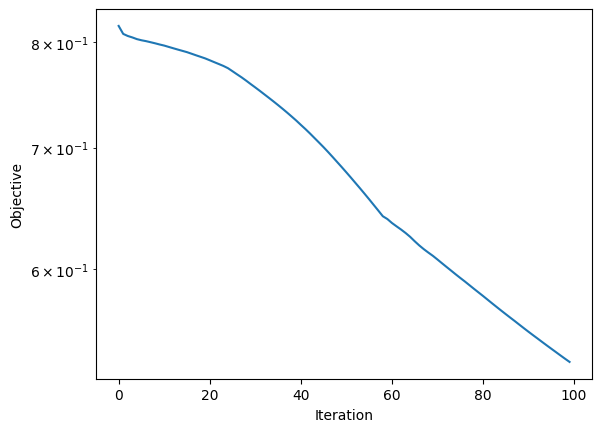

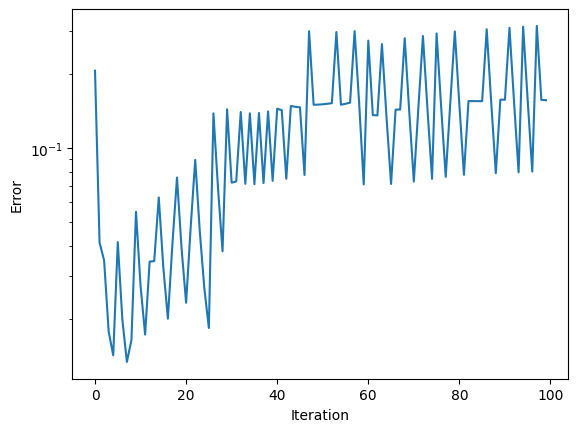

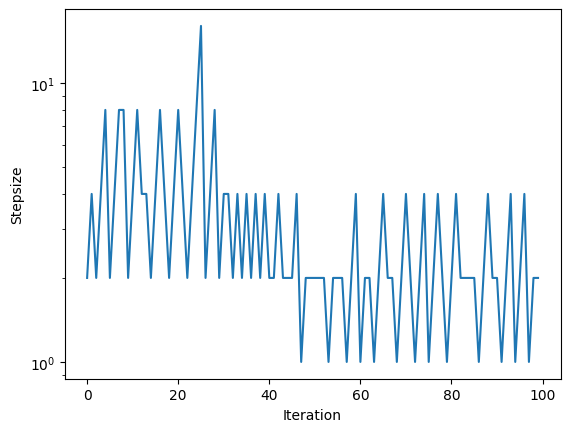

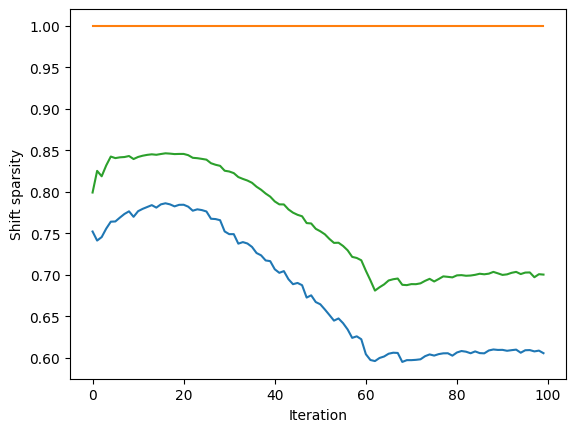

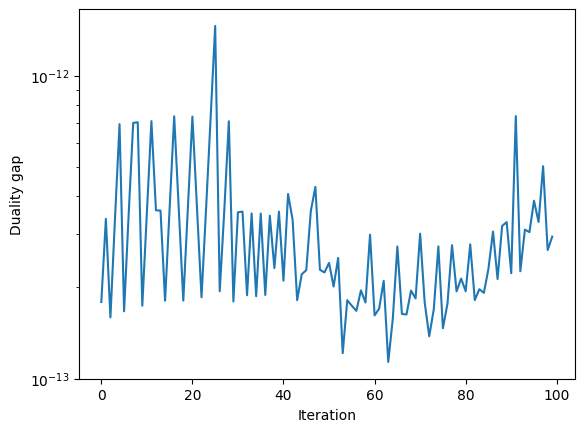

In [50]:
plt.plot(obj)
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.yscale("log")
plt.show()

plt.plot(error)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.yscale("log")
plt.show()

plt.plot(stepsize)
plt.xlabel("Iteration")
plt.ylabel("Stepsize")
plt.yscale("log")
plt.show()

plt.plot(sparsity)
plt.xlabel("Iteration")
plt.ylabel("Shift sparsity")
# plt.yscale("log")
plt.show()

if any(duality_gap):
    plt.plot(duality_gap)
    plt.xlabel("Iteration")
    plt.ylabel("Duality gap")
    plt.yscale("log")
    plt.show()

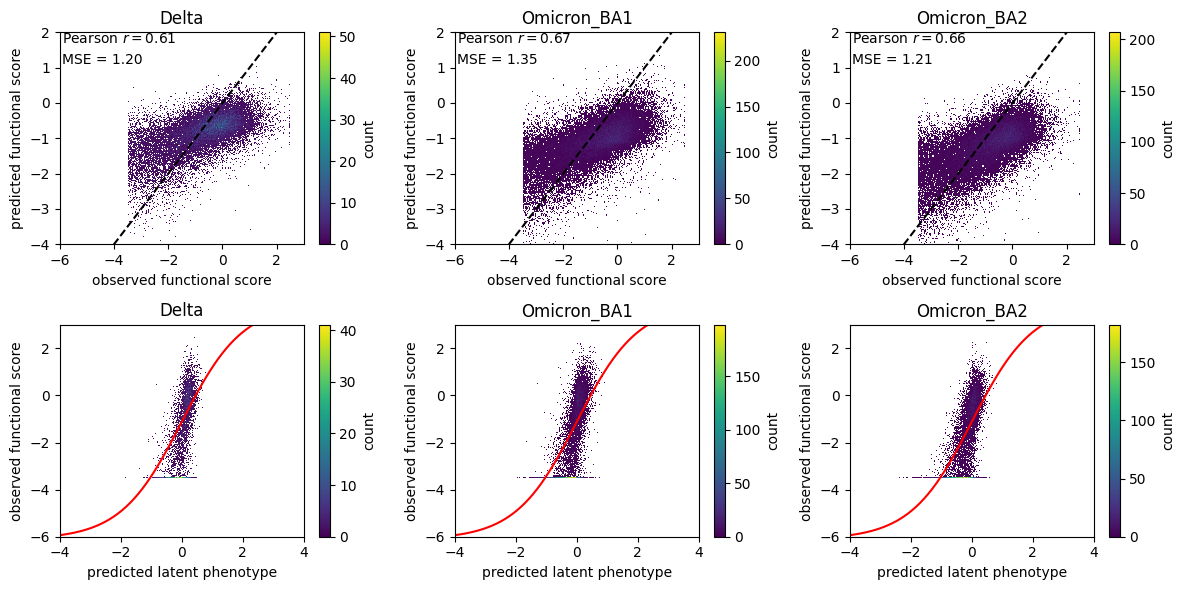

In [51]:
# make subplot with condition specific parameter sets on the columns.
# on the first row, plot the observed func score on x and predicted func score on y (y_pred_fn(params, data)) 
# on the second row, plot the predicted latent phenotype (φ_pred_fn(params, data)) on x and predicted function score (y_pred_fn(params, data))
y_pred = y_pred_fn(params, scaled_data)
φ_pred = φ_pred_fn(params, scaled_data)
fig, ax = plt.subplots(2, len(params['β'].keys()), figsize=(12, 6))
for i, d in enumerate(params['β'].keys()):
    sns.histplot(x=scaled_data["y"][d], y=y_pred[d], bins=200, cmap="viridis", cbar=True, cbar_kws={"label": "count"}, ax=ax[0, i])
    # add correlation
    ax[0, i].annotate(f"Pearson $r={scipy.stats.pearsonr(scaled_data['y'][d], y_pred[d]).statistic:.2f}$",
                    xy=(0.01, 0.95), xycoords="axes fraction")
    # mean squared error
    mse = jnp.mean((scaled_data["y"][d] - y_pred[d])**2)
    ax[0, i].annotate(f"MSE = {mse:.2f}",
                    xy=(0.01, 0.85), xycoords="axes fraction")
    ax[0, i].plot([-6, 3], [-6, 3], "k--")
    ax[0, i].set_xlim(-6, 3)
    ax[0, i].set_ylim(-4, 2)
    ax[0, i].set_xlabel("observed functional score")
    ax[0, i].set_ylabel("predicted functional score")
    ax[0, i].set_title(d)
    sns.histplot(x=φ_pred[d], y=scaled_data["y"][d], bins=300, cmap="viridis", cbar=True, cbar_kws={"label": "count"}, ax = ax[1, i])
    
    # plot sigmoid using fit parameters
    x = np.linspace(-8  , 5, 100)
    y = g_pred_fn(params["θ"], x)
    ax[1, i].plot(x, y, "r")
    # ax[1, i].plot([-6, 3], [-6, 3], "k--")
    ax[1, i].set_xlim(-4, 4)
    ax[1, i].set_ylim(-6, 3)
    ax[1, i].set_xlabel("predicted latent phenotype")
    ax[1, i].set_ylabel("observed functional score")
    ax[1, i].set_title(d)
plt.tight_layout()
plt.show()

In [52]:
params

{'theta_bias': Array([-3.5], dtype=float64),
 'theta_scale': Array([6.], dtype=float64),
 'Δ': array([[ 0.        , -0.14617129, -0.11834745, ..., -0.31510181,
          0.00039893,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        , -0.        ,  0.        , ..., -0.19540583,
         -0.0108999 , -0.        ]]),
 'θ': {'theta_bias': Array([-6.11416316], dtype=float64),
  'theta_scale': Array([10.], dtype=float64)},
 'β': {'Delta': Array([ 0.00134641, -0.32854641, -0.15633735, ...,  0.19753629,
          0.10689484,  0.01130504], dtype=float64),
  'Omicron_BA1': Array([ 0.00134641, -0.18237512, -0.0379899 , ...,  0.5126381 ,
          0.10649591,  0.01130504], dtype=float64),
  'Omicron_BA2': Array([ 0.00134641, -0.18237512, -0.0379899 , ...,  0.31723226,
          0.09559601,  0.01130504], dtype=float64)},
 'β0': {'Delta': Array(0.17052872, dtype=float64),
  'Omicron_BA1': Array(0., dtype=float64),


In [53]:
print(params["Δ"][0])

[ 0.         -0.14617129 -0.11834745 ... -0.31510181  0.00039893
  0.        ]


In [54]:
list(params["β"].keys())

['Delta', 'Omicron_BA1', 'Omicron_BA2']

In [55]:
# string format the D matrix to show the beta coefficients
D_str = []
for i, row in enumerate(D):
    D_str.append(
        " + ".join([f"{'-' if coef == -1 else ''}β{j+1} ({list(params['β'].keys())[j]})" 
        for j, coef in enumerate(row) if coef != 0.0])
    )
D_str

['β1 (Delta) + -β2 (Omicron_BA1)', '', '-β2 (Omicron_BA1) + β3 (Omicron_BA2)']

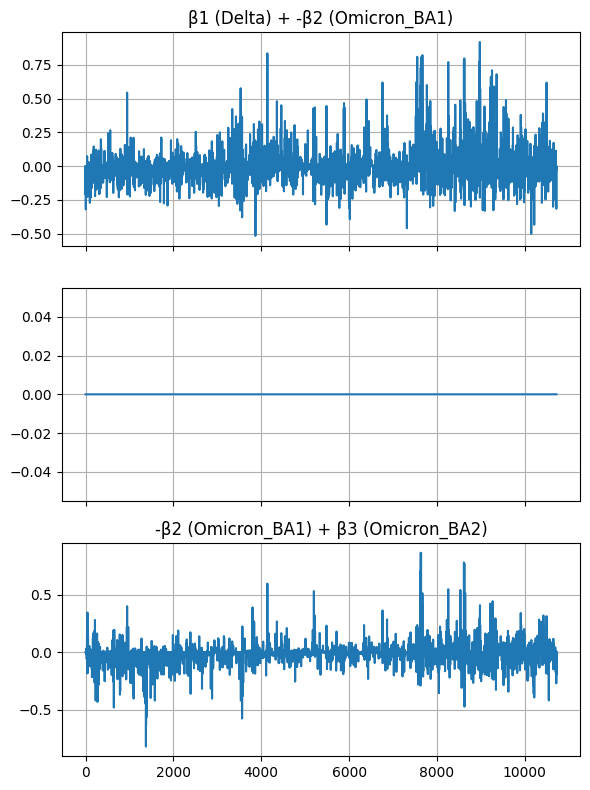

In [56]:
# triangle diff
fig, ax = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
for i, d in enumerate(params["Δ"]):
    # print(params["Δ"][d])
    ax[i].plot(params["Δ"][i])
    # plt.colorbar()
    ax[i].grid()
    ax[i].set_title(D_str[i])
plt.tight_layout()
plt.show()

In [57]:
data.mutations_df

,mutation,wts,sites,muts,times_seen_Delta,times_seen_Omicron_BA1,times_seen_Omicron_BA2
0,M1F,M,1,F,3.0,0.0,0.0
1,M1I,M,1,I,10.0,4.0,8.0
2,M1K,M,1,K,5.0,0.0,0.0
3,M1L,M,1,L,8.0,0.0,1.0
4,M1N,M,1,N,1.0,0.0,0.0
...,...,...,...,...,...,...,...
10717,S1252V,S,1252,V,14.0,57.0,65.0
10718,S1252W,S,1252,W,8.0,25.0,28.0
10719,S1252Y,S,1252,Y,35.0,84.0,151.0
10720,S1252*,S,1252,*,12.0,33.0,33.0
